# CS4243 Computer Vision Project


## Part 1: Setting up


In [11]:
# Function estimation using neural network, libraries

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import asarray
from matplotlib import pyplot as plt
import math as m
import random as r
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# We will do a simple check to see if we have GPU for training. Please use GPU to accelerate your training.

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Part 2: Train our model
We first load data using the `tf.keras.utils.image_dataset_from_directory` utility. We split the images from the train directory into two, to be used for training of the model and validating its performance (note that it is not for testing the final performance of the model).

You can view the output from these datasets which we loaded.

In [13]:
# setting the train and evaluation dataset directories. Change the below to your own path
# root_path = '/content/drive/MyDrive/CS4243 Project/data/frames/'
train_path = '/content/drive/MyDrive/CS4243 Project/data/image_data_cleaned'
test_path = '/content/drive/MyDrive/CS4243 Project/data/test_image_data_cleaned'
test_img = '/content/drive/MyDrive/CS4243 Project/data/frames/train/weap/0205705_20220904_0007_380.png'
test_img2 = '/content/drive/MyDrive/CS4243 Project/data/frames/test/weap/vlc-record-2022-09-04-23h02m05s-videoplayback (4)_360.png'


In [14]:
image_size = (256,256)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3363 files belonging to 2 classes.
Using 2691 files for training.
Found 3363 files belonging to 2 classes.
Using 672 files for validation.
Found 1931 files belonging to 2 classes.


In [ ]:
test_image = tf.keras.preprocessing.image.load_img(test_img, target_size=image_size)

test_image2 = tf.keras.preprocessing.image.load_img(test_img2, target_size=image_size)

#### Showing samples of images from train dataset

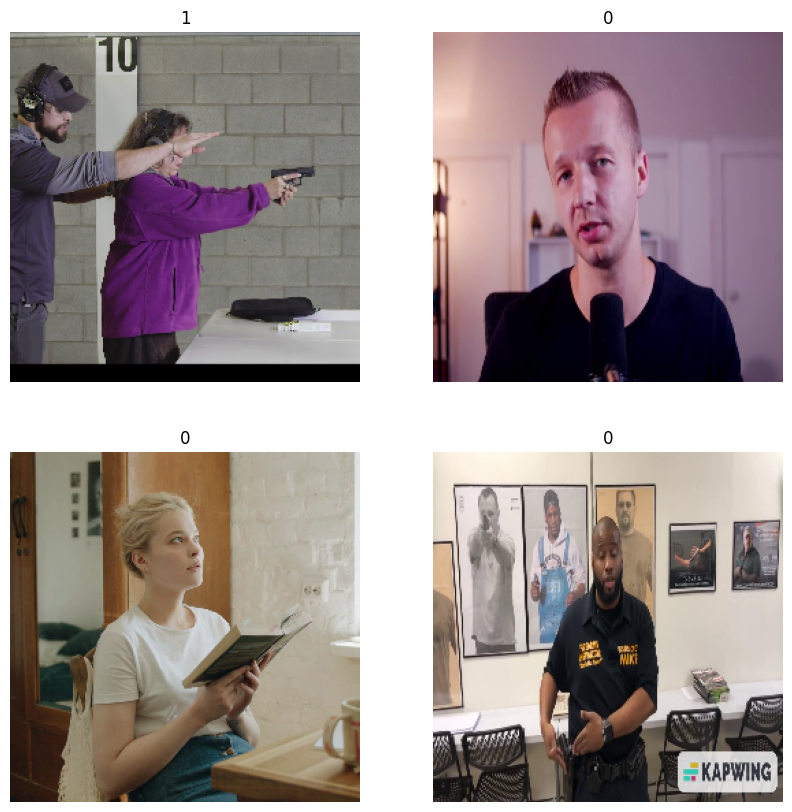

In [ ]:
# showing the images
#
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data augmentation
Using horizontal flip, and random rotation rotation factor is between 0 to 0.1*2pi


In [ ]:
# data augmentation, using horizontal flip, and random rotation
# rotation factor is between 0 to 0.1*2pi
#
mean = [0.485, 0.456, 0.406]
var = np.power(np.array([0.229, 0.224, 0.225]), 2)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.Normalization(mean=mean, variance=var),
        layers.experimental.preprocessing.Resizing(height=image_size[0], width=image_size[1]),
    ]
)


We define our model here which is essentially a Convolutional Neural Network. If you are not familiar with CNNs, I would recommend reading this <a href="https://aigents.co/data-science-blog/publication/introduction-to-convolutional-neural-networks-cnns">article</a> and this fun <a href="https://setosa.io/ev/image-kernels/">playground</a> (full credits to their corresponding authors.)

Some key points to help you understand some components below:
- Input() is used to instantiate a Keras tensor. It is more of a symbolic use rather than it meaning a mathematical operation - it's a way to define how the input data to the model should look.
- Batch normalization normalizes the activations of a layer to have zero mean and unit variance, helping to stabilize and accelerate training by reducing internal covariate shift.
- Residual refers to residual connections which allow gradients to "skip" layers by adding the original input to the output, helping to mitigate the vanishing gradient problem and enabling deeper networks to be trained more effectively.

FYI: Prof Amir uses Separable Convolutions layers here instead of the normal Conv2D layers you might be used to. Just note that this is just a variant of Convolution Layers, and at your own time may read up more about it. One resource is this <a href="https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728">link</a>. Understanding this specific layer is not the objective of today's lab.

In [ ]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

    # Convolutional Block 1
    x = layers.Conv2D(32, 3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)


    # Convolutional Block 2
    x = layers.Conv2D(64, 3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)

    # # Convolutional Block 3
    # x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # x = layers.BatchNormalization()(x)

    # # Convolutional Block 4
    # x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # x = layers.BatchNormalization()(x)


    x = layers.GlobalAveragePooling2D()(x)

    # x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    # x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Adding dropout for regularization
    x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.01))(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    return model


As we have learnt from week 10 lab session, we define our model, `compile` to configure our ANN's learning process, and use the `fit` method to start the training process of our model.

In [ ]:
model = make_model(input_shape=image_size + (3,) )

In [ ]:
# compiling and training our model

epochs = 20
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# This is a handy function in Keras that lets you look at your model which you have just compiled.
# Personally, looking at the output shape is particularly useful when you do CV

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496 

In [ ]:
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
337/337 [==============================] - 355s 1s/step - loss: 2.9603 - accuracy: 0.5801 - val_loss: 2.9244 - val_accuracy: 0.6310
Epoch 2/20
337/337 [==============================] - 85s 248ms/step - loss: 2.8744 - accuracy: 0.6254 - val_loss: 2.8296 - val_accuracy: 0.6533
Epoch 3/20
337/337 [==============================] - 86s 251ms/step - loss: 2.8064 - accuracy: 0.6310 - val_loss: 2.7581 - val_accuracy: 0.6652
Epoch 4/20
337/337 [==============================] - 86s 251ms/step - loss: 2.7438 - accuracy: 0.6421 - val_loss: 2.6970 - val_accuracy: 0.6562
Epoch 5/20
337/337 [==============================] - 82s 240ms/step - loss: 2.6894 - accuracy: 0.6395 - val_loss: 2.6386 - val_accuracy: 0.6577
Epoch 6/20
337/337 [==============================] - 86s 250ms/step - loss: 2.6289 - accuracy: 0.6529 - val_loss: 2.5825 - val_accuracy: 0.6533
Epoch 7/20
337/337 [==============================] - 83s 241ms/step - loss: 2.5737 - accuracy: 0.6537 - val_loss: 2.5275 - val_accu

#### Accuracy Curve

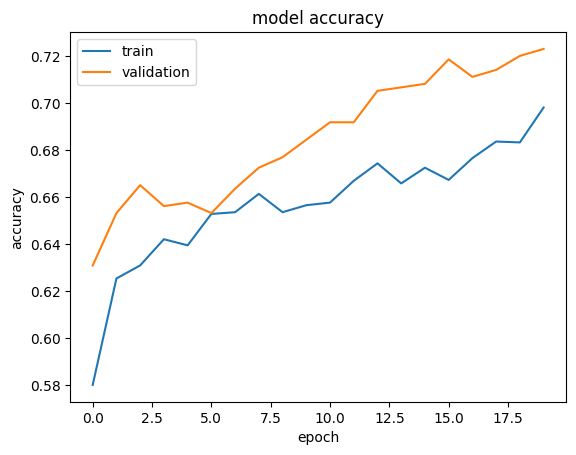

In [ ]:
# Accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Loss Curve

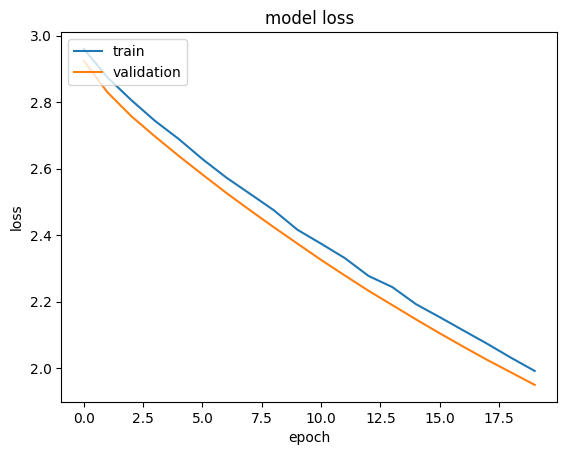

In [ ]:
# Loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Testing classifier with images

In [ ]:
# need a way to check the images and quantify them
predictions = model.predict(test_ds)
test_loss, test_accuracy = model.evaluate(test_ds)
true_labels = np.concatenate([labels for _ , labels in test_ds], axis=0)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
print(predicted_labels.ravel()[:10])
print(true_labels[:10])

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

TN, FP, FN, TP = confusion_matrix(true_labels, predicted_labels).ravel()
print(f"TN:{TN}")
print(f"FP:{FP}")
print(f"FN:{FN}")
print(f"TP:{TP}")

242/242 [==============================] - 32s 125ms/step - loss: 2.0561 - accuracy: 0.6339
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 1 1 0 0]
Confusion Matrix:
[[876 325]
 [508 222]]
TN:876
FP:325
FN:508
TP:222


In [ ]:
model.save('/content/drive/MyDrive/CS4243 Project/model_0.6339.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/CS4243 Project/model_0.6339.h5')

loaded_model2 = load_model('/content/drive/MyDrive/CS4243 Project/models/seannet_lrdecay00003_15_2block_2xL2_2xconvL2_leakyRelu.h5')

In [ ]:
# Load and preprocess the single image
def load_and_preprocess_image(file_path):
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Apply the load_and_preprocess_image function to the single image
preprocessed_image = load_and_preprocess_image(test_img)
preprocessed_image2 = load_and_preprocess_image(test_img2)

# Expand dimensions to match the model's input shape
preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)
preprocessed_image2 = tf.expand_dims(preprocessed_image2, axis=0)

# Now, you can use model.predict() on the preprocessed image
# predictions = loaded_model.predict(preprocessed_image)
# print(predictions)
# threshold = 0.5
# predicted_labels = (predictions > threshold).astype(int)
# print(predicted_labels)

predictions = loaded_model.predict(preprocessed_image2)
print(predictions)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
print(predicted_labels)

# predictions2 = loaded_model2.predict(preprocessed_image)
# print(predictions2)
# threshold = 0.5
# predicted_labels2 = (predictions2 > threshold).astype(int)
# print(predicted_labels2)

1/1 [==============================] - 0s 35ms/step
[[0.46169275]]
[[0]]


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
X_train = None
y_train = None
for image_batch, labels_batch in train_ds:
  X_train = image_batch.numpy()
  y_train = labels_batch.numpy()
  break

n_samples = X_train.shape[0]
n_features = np.prod(X_train.shape[1:])  # 256 * 256 * 3

# Reshape X_train to (32, 256 * 256 * 3)
X_train_reshaped = X_train.reshape(n_samples, n_features)

X_val = None
y_val = None
for image_batch, labels_batch in val_ds:
  X_val = image_batch.numpy()
  y_val = labels_batch.numpy()
  break

n_samples = X_val.shape[0]
n_features = np.prod(X_train.shape[1:])  # 256 * 256 * 3

# Reshape X_train to (32, 256 * 256 * 3)
X_val_reshaped = X_val.reshape(n_samples, n_features)

X_test = None
y_test = None
for image_batch, labels_batch in test_ds:
  X_test = image_batch.numpy()
  y_test = labels_batch.numpy()
  break

n_samples = X_test.shape[0]
n_features = np.prod(X_train.shape[1:])  # 256 * 256 * 3

# Reshape X_train to (32, 256 * 256 * 3)
X_test_reshaped = X_test.reshape(n_samples, n_features)

model = HistGradientBoostingClassifier(learning_rate=0.001)
model.fit(X_train_reshaped, y_val)

predictions = model.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.5
